# III. Training (VoxelMorph)
## Contents
0. Import / Setup

## 0. Import / Setup

In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne

In [15]:
# Constant Definition
DATA_PATH = './data/RIDER'
ModalityList = ['CT', 'PT']
RangeDict = {'CT':[0, 4095], 'PT':[0, 32767]}
ShapeList = [128, 128, 256]
TRAIN_IDX = np.arange(35)
VAL_IDX = np.arange(35,45)

## 1. Data Preparation

In [16]:
# Load
x_train = {'CT': np.zeros([len(TRAIN_IDX), *ShapeList]), 'PT': np.zeros([len(TRAIN_IDX), *ShapeList])}
x_val = {'CT': np.zeros([len(VAL_IDX), *ShapeList]), 'PT': np.zeros([len(VAL_IDX), *ShapeList])}

for i, idx in enumerate(TRAIN_IDX):
    for mod in ModalityList:
        x_train[mod][i] = np.load(os.path.join(DATA_PATH, '{}_{:02d}.npy'.format(mod, idx)))
for i, idx in enumerate(VAL_IDX):
    for mod in ModalityList:
        x_val[mod][i] = np.load(os.path.join(DATA_PATH, '{}_{:02d}.npy'.format(mod, idx)))

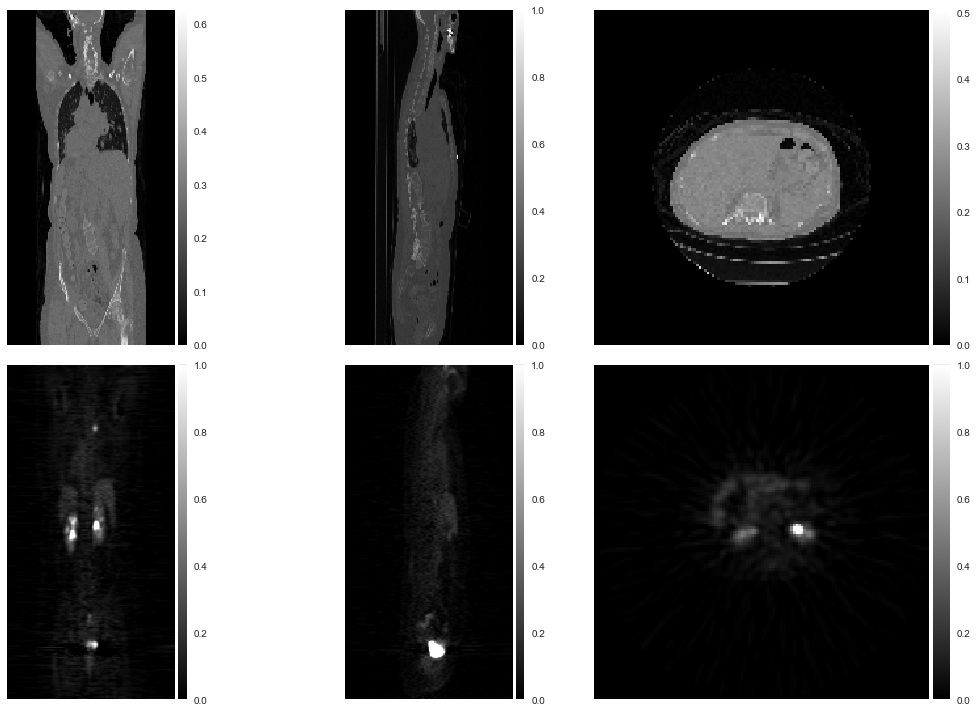

(<Figure size 1080x720 with 12 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

In [21]:
# Random Visualization
idx = np.random.randint(x_train['CT'].shape[0])
mid_slices_CT = [np.take(x_train['CT'][idx], ShapeList[d]//2, axis=d) for d in range(3)]
mid_slices_CT[0] = np.rot90(mid_slices_CT[0], -1)
mid_slices_CT[1] = np.rot90(mid_slices_CT[1], -1)

idx = np.random.randint(x_train['PT'].shape[0])
mid_slices_PT = [np.take(x_train['PT'][idx], ShapeList[d]//2, axis=d) for d in range(3)]
mid_slices_PT[0] = np.rot90(mid_slices_PT[0], -1)
mid_slices_PT[1] = np.rot90(mid_slices_PT[1], -1)

ne.plot.slices(mid_slices_CT + mid_slices_PT, cmaps=['gray'], do_colorbars=True, grid=[2,3])

In [17]:
# Data Generator Function
def vxm_data_generator(x_data, batch_size=32):
    # Data : [M, H, W]
    
    # Generation
    # Input : moving-img [N, H, W, 1], fixed-img [N, H, W, 1]
    # Output : moved-img [N, H, W, 1], zero-grad [N, H, W, 2]
    
    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [N, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # fixed_images : not used, just dummy data
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

2

In [22]:
len(x_train['CT'])

35